In [24]:
import os
import pickle
from collections import defaultdict, OrderedDict

import networkx as nx
import nxviz as nv
import pandas as pd

import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
import os

path_map = list()
for directory in os.listdir('../data/subgraphs_2/'):
    for file in os.listdir('../data/subgraphs_2/' + directory + '/'):
        poem_ind = file.split('.')[0]
        path_map.append((directory, poem_ind))

In [3]:
path_map[0]

('0', '1')

In [20]:
path_map_length = len(path_map)

similarity_scores = list()
for ind, (p1_ind, p2_ind) in enumerate(path_map):
    if ind % 10 == 0:
        print(f"{ind} -- {round((ind / path_map_length) * 100, 2)}%")
    
    subgraph = nx.read_gpickle(f"../data/subgraphs_2/{p1_ind}/{p2_ind}.gpickle")
    
    BASE_P1_IND = int(p1_ind)
    BASE_P2_IND = int(p2_ind)
    
    similarity_score = 0
    
    base_p1_nodes_data = [(node, data) for node, data in subgraph.nodes(data=True) if data['vector_ind'] == BASE_P1_IND]
    
    same_term_scores = 0
    same_term_lengh = 0
    # Add both tf-idf of P1Nn and P2Nn if they are the same words across poems, no synonyms
    for p1_node, data in base_p1_nodes_data:
        # This should only ever result in either 0 or 1 nodes
        p2_neighbors_tf_idf = [
            subgraph.node[n]['tf-idf'] for n in subgraph.neighbors(p1_node) 
            if subgraph.node[n]['vector_ind'] == BASE_P2_IND
        ]

        # if it is a one-to-one relationship
        if p2_neighbors_tf_idf:
            same_term_lengh += 1
            
            same_term_scores += data['tf-idf']

            for tf_idf in p2_neighbors_tf_idf:
                same_term_scores += tf_idf
                
    if same_term_scores:
        similarity_score += (same_term_scores / same_term_lengh)

    # Calculate scores for nodes that have synonym relationships
    for p1_node, p1_data in base_p1_nodes_data:
        # for all syns.. *denoted by -1
        for syn_node in [s_n for s_n in subgraph.neighbors(p1_node) if subgraph.node[s_n]['vector_ind'] == -1]:
            # all neighbors of syn matching P1Tn where neighbor is not in P1
            syn_p2_neighbors = [n for n in subgraph.neighbors(syn_node) if subgraph.node[n]['vector_ind'] != BASE_P1_IND]

            p2_syn_scores = 0
            # for all P2 nodes associated with the syn..
            for p2_node in syn_p2_neighbors:
                p2_syn_scores += (p1_data['tf-idf'] + subgraph.node[p2_node]['tf-idf'])

            similarity_score += (p2_syn_scores / (len(syn_p2_neighbors) * 2))
            
    try:
        similarity_score = similarity_score / len(subgraph.nodes())
    except ZeroDivisionError:
        print(p1_ind, p2_ind, subgraph.nodes(data=True))
        break
            
    # Tack on the scores for this combination
    similarity_scores.append((p1_ind, p2_ind, similarity_score))
    
print('Done')

0 -- 0.0%
10 -- 0.03%
20 -- 0.07%
30 -- 0.1%
40 -- 0.13%
50 -- 0.17%
60 -- 0.2%
70 -- 0.23%
80 -- 0.27%
90 -- 0.3%
100 -- 0.33%
110 -- 0.37%
120 -- 0.4%
130 -- 0.43%
140 -- 0.46%
150 -- 0.5%
160 -- 0.53%
170 -- 0.56%
180 -- 0.6%
190 -- 0.63%
200 -- 0.66%
210 -- 0.7%
220 -- 0.73%
0 8 []
Done


In [23]:
for ind, (p1_ind, p2_ind) in enumerate(path_map):
    subgraph = nx.read_gpickle(f"../data/subgraphs_2/{p1_ind}/{p2_ind}.gpickle")
    if len(subgraph.nodes()) == 0:
        print(p1_ind, p2_ind)

0 8
1 113
1 8
10 109
103 109
103 199
104 113
104 121
106 121
109 113
109 116
109 119
109 120
109 121
109 128
109 142
109 161
109 166
109 167
109 180
109 207
109 224
109 225
113 117
113 124
113 131
113 133
113 135
113 136
113 148
113 149
113 173
113 189
113 190
113 193
113 199
113 201
113 225
113 228
115 238
121 122
121 143
121 144
121 159
121 171
121 173
121 199
126 167
132 228
134 167
142 199
162 199
167 177
167 210
167 228
17 42
17 49
17 89
171 199
171 231
188 231
190 199
194 238
199 208
199 231
2 8
21 113
215 228
22 97
23 113
23 49
25 121
26 210
27 113
27 121
27 31
27 49
27 56
28 109
28 121
28 30
29 109
30 113
30 49
31 112
31 169
31 215
31 32
32 113
32 158
32 97
33 56
35 113
35 167
38 166
40 113
40 49
42 103
42 119
42 121
42 176
42 189
42 49
42 50
42 64
42 89
43 199
44 113
44 49
45 49
46 49
47 113
47 199
49 109
49 121
49 131
49 150
49 181
49 184
49 187
49 190
49 199
49 217
49 220
49 56
49 65
49 87
49 91
49 96
49 97
5 199
5 31
5 49
5 8
5 88
5 89
50 199
52 113
54 113
56 110
56 113
56 

In [82]:
from gensim.corpora import Dictionary
from nltk.corpus import wordnet as wn

syn_dictionary = Dictionary.load('../data/syn.dict')
term_dictionary = Dictionary.load('../data/spa.dict')


p1, p2 = '0', '8'

    
# Read in original subgraph
original_subgraph = nx.read_gpickle(f"../data/subgraphs/{p1}/{p2}.gpickle")

# Bring out the synonyms so that we can determine which nodes are associated
syn_nodes = list()
spa_nodes = list()
syn_neighbors = set()
for node, data in original_subgraph.nodes(data=True):
    # keep track of all syns
    if data['type'] == 'SYN':
        syn_nodes.append(node)

        # Keep track of all nodes that are associated with a synonym
        for syn_neighbor in original_subgraph.neighbors(node):
            syn_neighbors.add(syn_neighbor)

    # keep track of all spa nodes
    else:
        spa_nodes.append(node)


# Create a subgraph of the original, excluding the synonyms. 
# Ultimate goal is to re-map the synonyms with something we can read, 
# and right now they cant be read.
original_subgraph_without_syns = original_subgraph.subgraph(spa_nodes)
max_node = max(spa_nodes)


# I need to create a brand new graph, since I will ultimately be altering it. 
# Apparently, you cannot alter a subgraph.. SMH
new_graph = nx.Graph()

nodes_list = list()
edges_list = list()

# copy all nodes and edges of original, and create the new one
for node, data in original_subgraph_without_syns.nodes(data=True):
    data['term'] = term_dictionary[data['term_id']]
    nodes_list.append((node, data))
    for neighbor in original_subgraph_without_syns.neighbors(node):
        edges_list.append((node, neighbor))

new_graph.add_nodes_from(nodes_list)
new_graph.add_edges_from(edges_list)


# Now I need to include synonyms between the spa nodes
syns_per_term = defaultdict(set)
syn_to_node_map = dict()

nodes_to_keep = list()

# This is to ensure all values are unique within the subgraph
node_count = max_node + 1
for term_id in spa_nodes:
    # If a node from P1 is already connected to a node in P2, we don't want to find the syns
    if list(new_graph.neighbors(term_id)):
        nodes_to_keep.append(term_id)
        continue

    term = term_dictionary[new_graph.node[term_id]['term_id']]

    # make a call to the wordnet synsets api for the syns associated with the term
    term_syns = wn.synsets(term)

    for syn_obj in term_syns:
        # extracts the text value from the syn object
        syn = syn_obj.name().split('.')[0]

        if syn not in syn_dictionary.token2id:
            syn_dictionary.add_documents([[syn]])

        syn_dict_id = syn_dictionary.token2id[syn]

        # the syn doesn't yet exist with this subgraph
        if syn_dict_id not in syn_to_node_map:
            # add syn node to graph
            new_graph.add_node(
                node_count,
                type='SYN',
                term_id=syn_dict_id,
                freq_per_doc=-1,
                vector_ind=-1,
                doc_name='Synonyms'
            )
            syn_to_node_map[syn_dict_id] = {
                'node_id': node_count,
                'count': 0,
                'poem_types': set()
            }

            node_count += 1

        # sometimes, the same syn appears multiple times for a given word, to this fixes that
        if syn not in syns_per_term[term_id]:
            syns_per_term[term_id].add(syn)

            syn_to_node_map[syn_dict_id]['count'] += 1
            syn_to_node_map[syn_dict_id]['poem_types'].add(new_graph.node[term_id]['vector_ind'])

            new_graph.add_edge(
                term_id,
                syn_to_node_map[syn_dict_id]['node_id']
            )


            
shared_syns = list()
for syn_dict_id, desc in syn_to_node_map.items():
    if desc['count'] > 1 and len(desc['poem_types']) > 1:
        print('here')
        shared_syns.append(desc['node_id'])
        nodes_to_keep.extend(new_graph.neighbors(desc['node_id']))

new_graph_with_sim_syn = new_graph.subgraph(shared_syns + nodes_to_keep)

In [83]:
len(term_dictionary)

6019

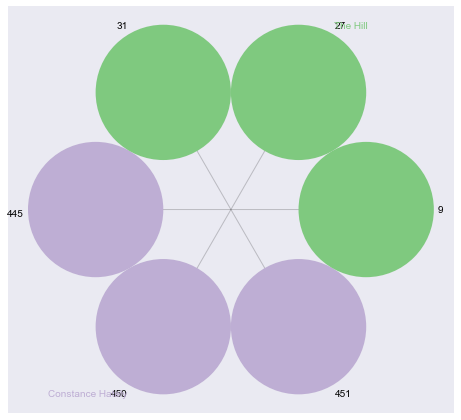

In [84]:
# They are the same
ap = nv.CircosPlot(
    new_graph_with_sim_syn, 
    node_color='vector_ind', 
    node_order='term_id', 
    node_grouping='doc_name', 
    group_label_position='middle',
    group_label_color=True,
    node_labels=True,
    figsize=(8, 8)
)

ap.draw()
plt.show();

In [85]:
new_graph_with_sim_syn.nodes(data=True)

NodeDataView({450: {'vector_ind': 8, 'term_id': 390, 'freq_per_doc': 2.0, 'type': 'SPA', 'tf-idf': 0.0973765539810819, 'doc_name': 'Constance Hately', 'term': 'them'}, 451: {'vector_ind': 8, 'term_id': 439, 'freq_per_doc': 3.0, 'type': 'SPA', 'tf-idf': 0.1901363953163849, 'doc_name': 'Constance Hately', 'term': 'their'}, 9: {'vector_ind': 0, 'term_id': 61, 'freq_per_doc': 3.0, 'type': 'SPA', 'tf-idf': 0.01553706857816887, 'doc_name': 'The Hill', 'term': 'with'}, 27: {'vector_ind': 0, 'term_id': 390, 'freq_per_doc': 1.0, 'type': 'SPA', 'tf-idf': 0.019723632953151892, 'doc_name': 'The Hill', 'term': 'them'}, 445: {'vector_ind': 8, 'term_id': 61, 'freq_per_doc': 1.0, 'type': 'SPA', 'tf-idf': 0.01278454634180413, 'doc_name': 'Constance Hately', 'term': 'with'}, 31: {'vector_ind': 0, 'term_id': 439, 'freq_per_doc': 1.0, 'type': 'SPA', 'tf-idf': 0.025674766795741134, 'doc_name': 'The Hill', 'term': 'their'}})

In [86]:
syn_dictionary[390]

'estimate'

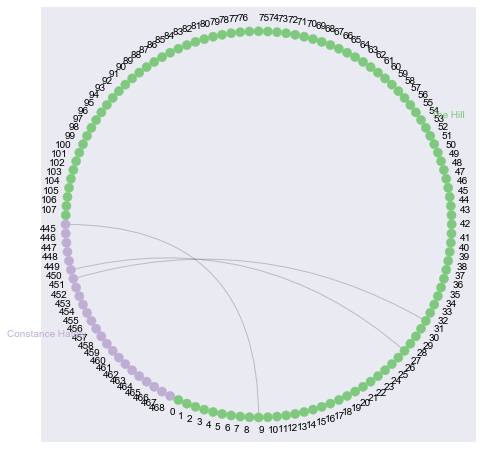

In [72]:
subgraph = nx.read_gpickle("../data/subgraphs/0/8.gpickle")

# They are the same
ap = nv.CircosPlot(
    subgraph, 
    node_color='vector_ind', 
    node_order='term_id', 
    node_grouping='doc_name', 
    group_label_position='middle',
    group_label_color=True,
    node_labels=True,
    figsize=(8, 8)
)

ap.draw()
plt.show();

In [22]:
subgraph.nodes()

NodeView(())

In [6]:
pickle.dump(similarity_scores, open('../data/final_similarity_scores.p', 'wb'))

In [7]:
# now to actually create the matrix
similarities_map = defaultdict(dict)
max_score = 0

# baseline for the matrix
for p1, p2, similarity_score in similarity_scores:
    similarities_map[p1][p2] = similarity_score
    similarities_map[p2][p1] = similarity_score
    
    max_score = similarity_score if similarity_score > max_score else max_score
        
    
# establish identity
for i in range(len(similarities_map)):
    similarities_map[str(i)][str(i)] = 0

In [8]:
max_score

22.00350407903306

In [9]:
assert len(similarities_map) == 246
for i in range(246):
    assert len(similarities_map[str(i)]) == 246

In [10]:
similarities_matrix = pd.DataFrame(
    {str(i): [similarities_map[str(i)][str(j)] / max_score for j in range(len(similarities_map[str(i)]))] for i in range(len(similarities_map))}
)

In [11]:
similarities_matrix.head(10)

,0,1,2,3,4,5,6,7,8,9,...,236,237,238,239,240,241,242,243,244,245
0,0.000000,0.072986,0.052673,0.061880,0.066981,0.008971,0.006384,0.045952,0.000000,0.043080,...,0.060702,0.064085,0.017792,0.074228,0.050016,0.043099,0.060251,0.081558,0.162918,0.219080
1,0.072986,0.000000,0.083302,0.121830,0.065119,0.062420,0.049478,0.012945,0.000000,0.180232,...,0.172973,0.087483,0.076408,0.218247,0.126286,0.092570,0.057702,0.094820,0.314887,0.304857
2,0.052673,0.083302,0.000000,0.091304,0.081676,0.042141,0.029771,0.037021,0.000000,0.050947,...,0.157870,0.135367,0.036970,0.065189,0.038921,0.057197,0.042161,0.096939,0.224916,0.264412
3,0.061880,0.121830,0.091304,0.000000,0.137990,0.100286,0.073273,0.026355,0.006670,0.216768,...,0.140151,0.133741,0.029822,0.244909,0.118744,0.082516,0.146362,0.153038,0.326751,0.382005
4,0.066981,0.065119,0.081676,0.137990,0.000000,0.064485,0.050140,0.059265,0.006250,0.044340,...,0.149491,0.103070,0.020457,0.076232,0.165007,0.103002,0.081882,0.072925,0.302354,0.295996
5,0.008971,0.062420,0.042141,0.100286,0.064485,0.000000,0.110063,0.041576,0.000000,0.062737,...,0.192152,0.108617,0.017116,0.095241,0.142788,0.049819,0.068273,0.098677,0.122121,0.198651
6,0.006384,0.049478,0.029771,0.073273,0.050140,0.110063,0.000000,0.060010,0.014180,0.052605,...,0.091751,0.045068,0.037327,0.111907,0.059609,0.057088,0.138824,0.049791,0.163569,0.228702
7,0.045952,0.012945,0.037021,0.026355,0.059265,0.041576,0.060010,0.000000,0.000000,0.025069,...,0.019461,0.009583,0.015187,0.066709,0.033979,0.035668,0.054434,0.031571,0.151139,0.213346
8,0.000000,0.000000,0.000000,0.006670,0.006250,0.000000,0.014180,0.000000,0.000000,0.004558,...,0.021321,0.000000,0.029691,0.000000,0.004495,0.000000,0.029204,0.003992,0.039573,0.037126
9,0.043080,0.180232,0.050947,0.216768,0.044340,0.062737,0.052605,0.025069,0.004558,0.000000,...,0.040182,0.057015,0.007868,0.197390,0.122665,0.054771,0.035371,0.065505,0.110004,0.167027


In [12]:
# Get the top 3 scores from each row
n_largest = dict()
for i in range(len(similarities_matrix)):
    str_ind = str(i)
    
    top_3_vals = similarities_matrix.nlargest(3, str_ind).loc[:, str_ind].tolist()
    top_3_index = similarities_matrix.nlargest(3, str_ind).loc[:, str_ind].index.tolist()
    
    n_largest[str_ind] = list(zip(top_3_vals, top_3_index))

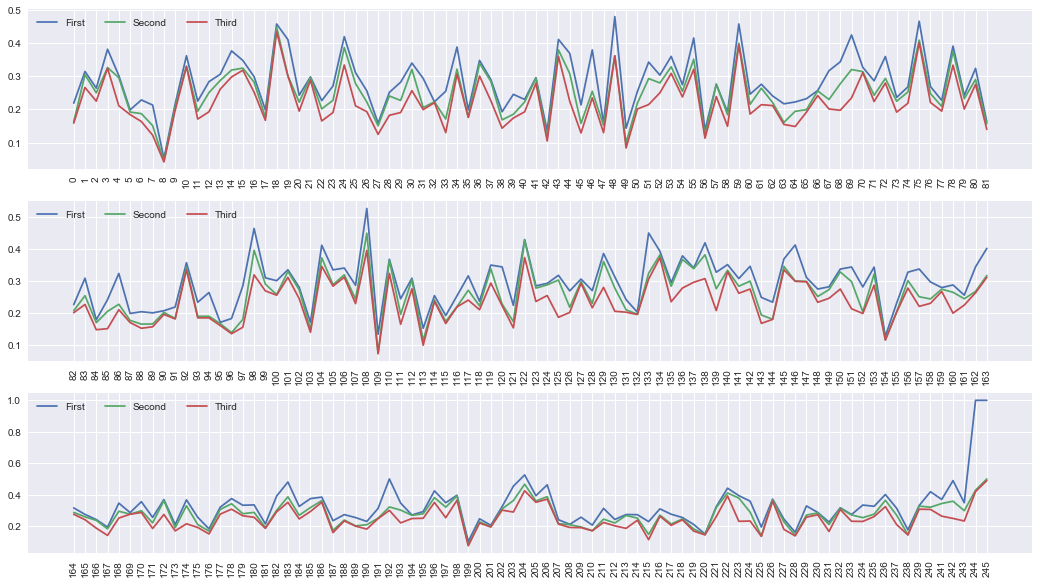

In [13]:
import seaborn as sns

sns.set()

scores = []
for n_set in n_largest.values():
    scores.append([score for score, ind in n_set])

n_largest_keys = list(n_largest.keys())

f = plt.figure(figsize=(18, 10))

base = 82
for i in range(3):
    ax = f.add_subplot(3, 1, i + 1)
    
    # same plotting code as above!
    plt.plot(n_largest_keys[base*i:base*(i+1)], scores[base*i:base*(i+1)])
    plt.legend(['First', 'Second', 'Third'], ncol=3, loc='upper left');
    plt.xticks(rotation=90)
    
plt.show();

In [16]:
n_largest

{'0': [(0.2190802007254723, 245),
  (0.16291750064274504, 244),
  (0.15860120137340405, 204)],
 '1': [(0.31488654008981826, 244),
  (0.30485749455140015, 245),
  (0.266389346675102, 18)],
 '2': [(0.2644118269891164, 245),
  (0.2503440701930343, 186),
  (0.22505689684587044, 44)],
 '3': [(0.38200515358224896, 245),
  (0.32675065373315704, 244),
  (0.324547305733341, 122)],
 '4': [(0.30235431926508927, 244),
  (0.29599609628501655, 245),
  (0.21102676425577094, 10)],
 '5': [(0.19865091602070226, 245),
  (0.19215204707705894, 236),
  (0.1844707114916918, 186)],
 '6': [(0.22870190624611328, 245),
  (0.18735528747769598, 150),
  (0.16356916147527742, 244)],
 '7': [(0.2133456060020339, 245),
  (0.1511385362450037, 244),
  (0.12228736300493902, 204)],
 '8': [(0.051752185916905835, 141),
  (0.0439459377350855, 138),
  (0.04133480493248519, 153)],
 '9': [(0.21676843387024924, 3),
  (0.20829400186810382, 182),
  (0.1973900938985843, 239)],
 '10': [(0.36225750534422435, 244),
  (0.331103878968911